## Intro
We can use both traditional statistical and neural network methods to analysis Time series data
* Key components: **trend**(mono direction), **seasonality**(may/may not having trend), **cyclicity**, **irrregular** 
* Time series can be devided into 2 catogories : stationary series(no trend) and non-stationary series(contains one or multiple key conponents above)


* Statistic analysis. 
    * AR(Auto regression) linear combination of data in previous (p) time points + current irregular 
    * MA (Moving Average): linear combination of irregular in previous (q) time points + current irregular
    * ARMA = AR + MA. Auto regressive moving average
    * ARIMA(Auto Regressive Intergrated Moving Average). For non-stationary series, integrated means to calculate the differencing of raw observation(e.g.(d) times keep moving subtracting an observation from an observation at the previous time step) in order to make the time series stationarycurrent value Integrated. 
    
* Neural network- LSTM(long short term memory)
    

## Statistic analysis
### Case1: ARMA time series simple analysis
Simple simutation: Using 1901 -1990 data to predict trend from 1991-2000

In [4]:
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

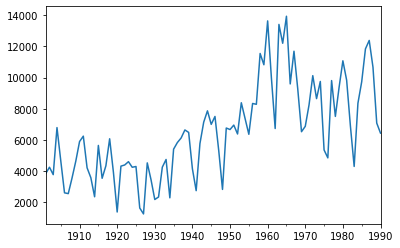

In [8]:
data = [3821, 4236, 3758, 6783, 4664, 2589, 2538, 3542, 4626, 5886, 6233, 4199, 3561, 2335, 5636, 3524, 
4327, 6064, 3912, 1356, 4305, 4379, 4592, 4233, 4281, 1613, 1233, 4514, 3431, 2159, 2322, 4239, 4733, 
2268, 5397, 5821, 6115, 6631, 6474, 4134, 2728, 5753, 7130, 7860, 6991, 7499, 5301, 2808, 6755, 6658, 
6944, 6372, 8380, 7366, 6352, 8333, 8281, 11548, 10823, 13642, 9973, 6723, 13416, 12205, 13942, 9590, 
11693, 9276, 6519, 6863, 8237, 10122, 8646, 9749, 5346, 4836, 9806, 7502, 9387, 11078, 9832, 6886, 4285, 
8351, 9725, 11844, 12387, 10666, 7072, 6429]
data = pd.Series(data)
data_index = sm.tsa.datetools.dates_from_range('1901', '1990')
# data_index # datetime.datetime(1901, 12, 31, 0, 0)

# plot the data
data.index = pd.Index(data_index)
data.plot(figsize=(6, 4))
plt.show()

In [10]:
# create ARMA model
arma = ARMA(data,order = (7,0)).fit()
print('AIC: %0.4lf' %arma.aic)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


AIC: 1615.9965


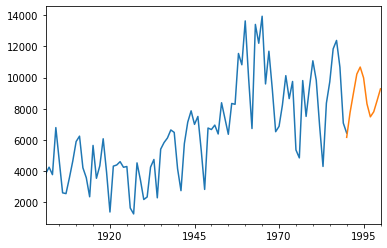

In [13]:
# predict and plot the result
predict_y = arma.predict('1990', '2000')

ax = data.loc['1901':].plot()
predict_y.plot(ax =ax)
plt.show()

### Case 2: stock trend simple analysis

**Thought**
* read data.set date as index.explore the data by week month and year
* generate p,q,d series to grid search the best parameter within SARIMAX/ARMA/AR model and using month resample data
* generate future date_range we want to predict and further generate new DataFrame with new data range as index. This data range is based on the last value in existed dataset
* concate new DataFrame with the existed Dataframe
* use the best model to predict the date range
* visualise the whole resutl
#### (ARIMA)SARIMAX model

In [19]:
import pandas as pd
import numpy as np
from itertools import product
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
%matplotlib inline 

warnings.filterwarnings('ignore')

In [11]:
# read data and explore the data
df = pd.read_csv('./Data/shanghai_index_1990_12_19_to_2020_03_12.csv')
df = df[['Timestamp', 'Price']]
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index(['Timestamp'],inplace =True)
print(df.shape)
print(df.head())
df.tail()

(7145, 1)
             Price
Timestamp         
1990-12-19   99.98
1990-12-20  104.39
1990-12-21  109.13
1990-12-24  114.55
1990-12-25  120.25


,Price
Timestamp,
2020-03-06,3034.5113
2020-03-09,2943.2907
2020-03-10,2996.7618
2020-03-11,2968.5174
2020-03-12,2923.4856


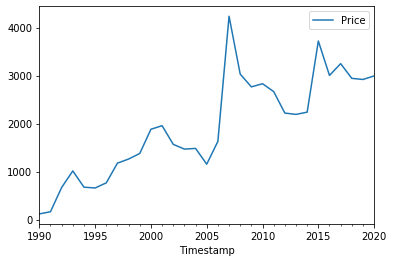

In [23]:
# explore data by month, quarter and year
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-Dec').mean()
df_year.plot()
plt.show()

In [29]:
# generate p,q,d series to grid search the best parameter within SARIMAX mode 
# through finding lowest aic
ps = range(0, 5)
qs = range(0, 5)
ds = range(1,3)
# parameter_list: [(0, 1, 0), (0, 1, 1),..(4, 2, 3), (4, 2, 4)]
parameter_list = list(product(ps,ds,qs))
results = []
best_aic = float("inf")
for param in parameter_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                         order=(param[0], param[1], param[2]),
                                         enforce_stationariry = False).fit()
        
    except ValueError:
        print('ValueError:', param)
        continue
    aic= model.aic
    if aic <best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([best_param, best_model])
    
print('best model:', best_model.summary())

best model:                            Statespace Model Results                           
Dep. Variable:                  Price   No. Observations:                  352
Model:               SARIMAX(4, 2, 1)   Log Likelihood               -2277.358
Date:                Wed, 16 Feb 2022   AIC                           4566.715
Time:                        07:32:07   BIC                           4589.863
Sample:                    12-31-1990   HQIC                          4575.929
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3355      0.051      6.594      0.000       0.236       0.435
ar.L2          0.0135      0.038      0.353      0.724      -0.061       0.088
ar.L3         -0.1081      0.029     -3.

In [40]:
# generate future date_range we want to predict (like future 3 month)
# further generate new DataFrame with new data range as index. 
# This data range is based on the last value in existed dataset
df_month2 = df_month[['Price']]
future_month = 3
last_month = df_month2.index[len(df_month2)-1]
date_list = []
for _ in range(future_month):
     #calculate how many days of next month
        year = last_month.year
        month = last_month.month
        if month == 12:
            month = 1
            year += 1
        else:
            month +=1
        # The monthrange() method is used to get weekday of first day
        # of the month and number of days in month
        next_month_days = calendar.monthrange(year,month)[1]
        last_month += timedelta(days = next_month_days)
        date_list.append(last_month)
date_list


[Timestamp('2020-04-30 00:00:00', freq='M'),
 Timestamp('2020-05-31 00:00:00', freq='M'),
 Timestamp('2020-06-30 00:00:00', freq='M')]

In [43]:
# concate new DataFrame with the existed Dataframe
future = pd.DataFrame(index = date_list, columns = df_month.columns)
df_month2 = pd.concat([df_month2, future])

In [46]:
df_month2['forcast'] = best_model.get_prediction(start =0,
                                                end = len(df_month2)).predicted_mean

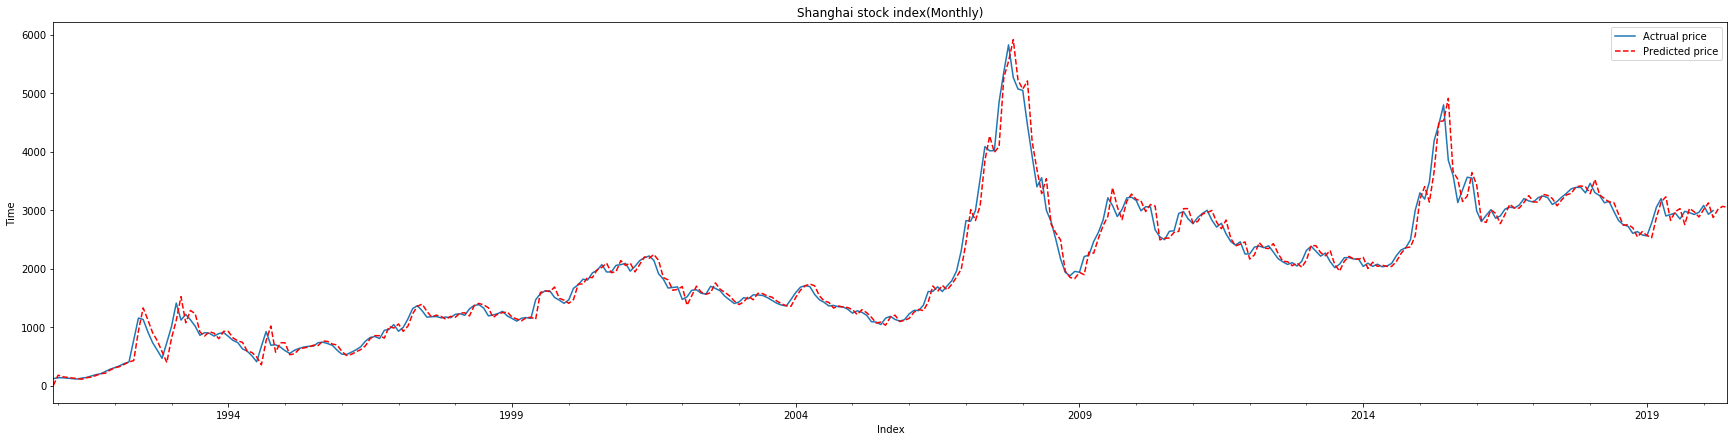

In [48]:
# visualize the result
plt.figure(figsize=(30,7))
df_month2['Price'].plot(label ='Actrual price')
df_month2.forcast.plot(label ='Predicted price', color ='r',ls ='--')
plt.legend()
plt.title('Shanghai stock index(Monthly)')
plt.ylabel('Time')
plt.xlabel('Index')
plt.show()

#### ARMA model

In [19]:
import pandas as pd
import numpy as np
from datetime import timedelta
import calendar
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.arima_model import ARMA
%matplotlib inline

In [6]:
# read data and explore the data
df = pd.read_csv('./Data/shanghai_index_1990_12_19_to_2020_03_12.csv',parse_dates=['Timestamp'])
df = df[['Timestamp', 'Price']]
df.set_index('Timestamp', inplace = True)
df.tail()

,Price
Timestamp,
2020-03-06,3034.5113
2020-03-09,2943.2907
2020-03-10,2996.7618
2020-03-11,2968.5174
2020-03-12,2923.4856


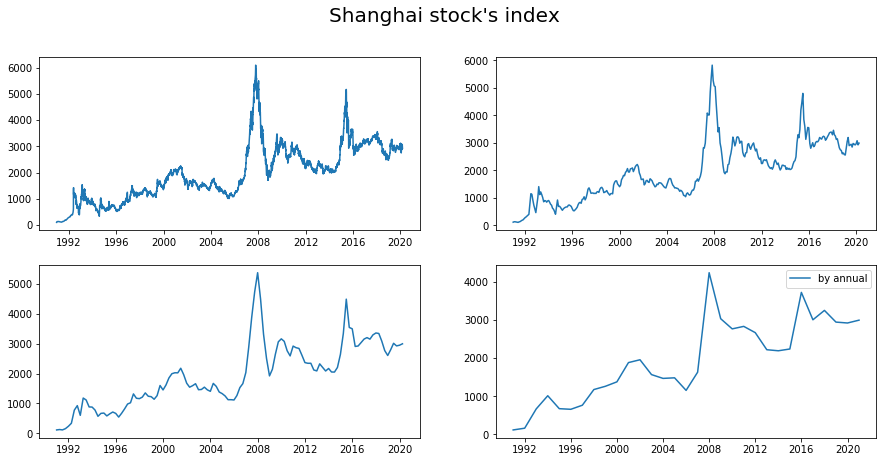

In [14]:
# resample the file and visualize them
df_month = df.resample('M').mean()
df_quarter = df.resample('Q-Dec').mean()
df_annual = df.resample('A-Dec').mean()

fig = plt.figure(figsize=[15,7])
plt.suptitle("Shanghai stock's index", fontsize =20)
plt.subplot(221)
plt.plot(df.Price, '-', label ='by day')
plt.subplot(222)
plt.plot(df_month.Price, '-', label = 'by month')
plt.subplot(223)
plt.plot(df_quarter.Price, '-', label ='by quarter')
plt.subplot(224)
plt.plot(df_annual.Price, '-', label ='by annual')
plt.legend()
plt.show()

Parameter value error (0, 2)
Parameter value error (0, 3)
Parameter value error (0, 4)
Best model:                               ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  352
Model:                     ARMA(2, 4)   Log Likelihood               -2285.195
Method:                       css-mle   S.D. of innovations            158.703
Date:                Sat, 19 Feb 2022   AIC                           4586.390
Time:                        07:12:34   BIC                           4617.299
Sample:                    12-31-1990   HQIC                          4598.690
                         - 03-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1921.6212    381.902      5.032      0.000    1173.107    2670.136
ar.L1.Price     1.6608      0

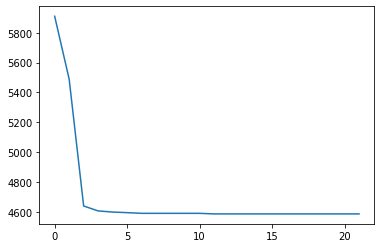

In [43]:
# find the best model
p = range(0,5)
q = range(0,5)
params= list(product(p,q))
best_aic = np.float('inf')
results=[]
for param in params:
    try:
        model = ARMA(df_month, order=param).fit()
#          model = ARMA(df_month, order=( param[0], param[1])).fit()
    except ValueError:
        print('Parameter value error',param)
        continue
        
    if model.aic < best_aic:
        best_aic= model.aic
        best_model = model
    
    results.append([param, best_aic])
    
print(f'Best model: {best_model.summary()}')
# show the trend of aic
pd.Series([sub[-1] for sub in results]).plot()
plt.show()

In [53]:
# Generate the future time series and predict
df_month2 = df_month[['Price']]
last_month= df_month.index[len(df_month)-1]
future = 3
date_list =[]
for _ in range(future):
    year = last_month.year
    month = last_month.month
    if month == 12:
        year += 1
        month == 1
    else:
        month += 1
    month_day = calendar.monthrange(year, month)[1]
    last_month += timedelta(days = month_day) 
    date_list.append(last_month)
    

In [60]:
future = pd.DataFrame(index =date_list, columns = df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start =0, end = len(df_month2))
# set NaN for the 1st forecast value for it is not right 
df_month2['forecast'][0] =np.NaN
df_month2.tail()

,Price,forecast
2020-02-29,2927.513035,3093.596140
2020-03-31,2990.415289,2833.302639
2020-04-30,NaN,2997.489856
2020-05-31,NaN,3022.451965
2020-06-30,NaN,2958.107335


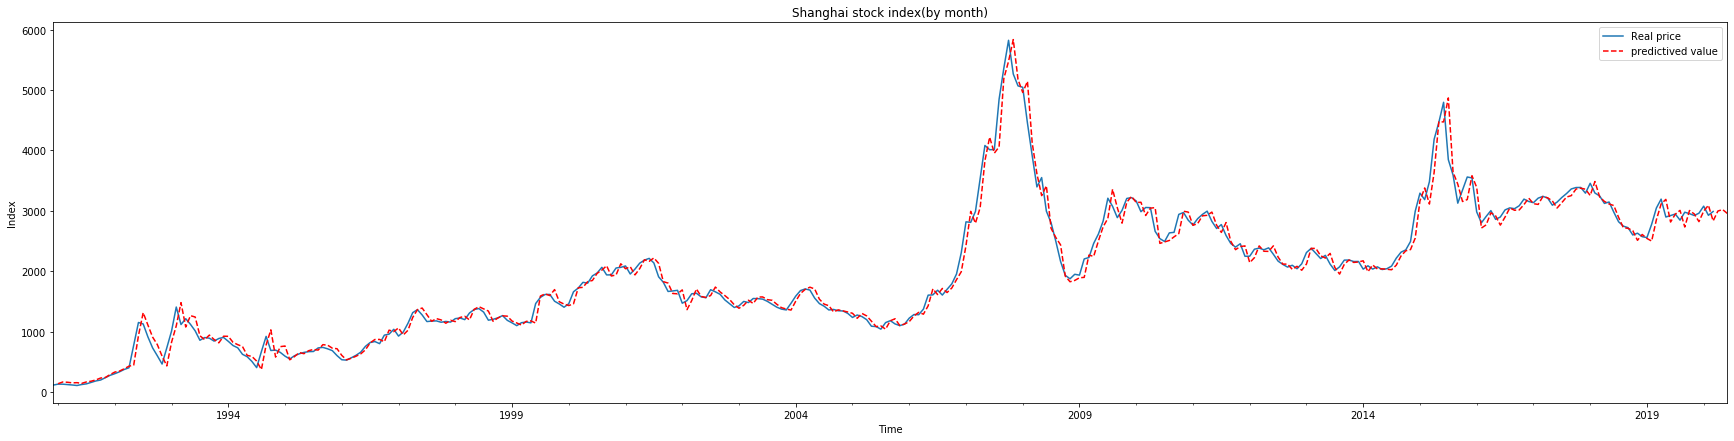

In [70]:
plt.figure(figsize=(30,7))
df_month2.Price.plot(label ='Real price')
df_month2.forecast.plot(label = 'predictived value', color='red', ls ='--')
plt.legend()
plt.title('Shanghai stock index(by month)')
plt.xlabel('Time')
plt.ylabel('Index')
plt.show()

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7145 entries, 1990-12-19 to 2020-03-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   7145 non-null   float64
dtypes: float64(1)
memory usage: 111.6 KB


#### Time series analysis, finding trend, seasonal and residual

In [73]:
import statsmodels.api as sm

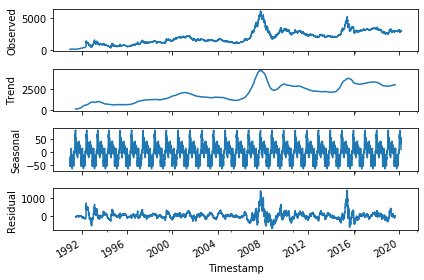

In [74]:
# using linear interpolation
df2 = df[['Price']]
df2.Price.interpolate(inplace = True)
# 250 trading days per year
result =sm.tsa.seasonal_decompose(df2.Price, freq =250)
result.plot()
plt.show()

#### Prophet prediction

In [ ]:
from fbprophet import Prophet

In [ ]:
!pip install fbprophet